In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [5]:
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o
4612,60085.289962,15.891,0.012,1597.0,20.0,o,0,7.68,295.57660,-20.54654,3483.49,4412.50,2.05,1.87,84.7,-0.423,19.29,20.65,04a60085o0743o
4613,60093.044580,18.811,0.103,108.0,11.0,c,0,1.20,295.57660,-20.54654,9278.83,6021.04,2.94,2.75,-33.6,-0.361,19.45,21.42,03a60093o0736c
4614,60093.047335,18.616,0.090,130.0,12.0,c,0,1.13,295.57660,-20.54654,9261.36,5982.77,2.91,2.67,-25.9,-0.358,19.48,21.42,03a60093o0742c


In [6]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604,60079.361159,14.678,0.007,4884.0,33.0,o,0,32.80,295.57660,-20.54654,7076.95,2279.83,2.18,1.95,-19.6,-0.419,19.20,20.49,04a60079o0524o
4605,60079.384530,15.696,0.079,1912.0,150.0,o,0,0.98,295.57660,-20.54654,3581.78,8256.05,2.52,1.91,-79.3,-0.404,16.73,18.41,04a60079o0571o
4610,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [7]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.393173,12.691,0.003,30460.0,76.0,o,0,65.80,295.57660,-20.54654,10453.99,1565.49,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
2,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
3,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
4,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
3302,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
3303,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
3304,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [8]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.727,0.002,29461.0,73.0,o,0,121.64,295.57660,-20.54654,2602.78,553.75,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
1789,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
1790,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
1791,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


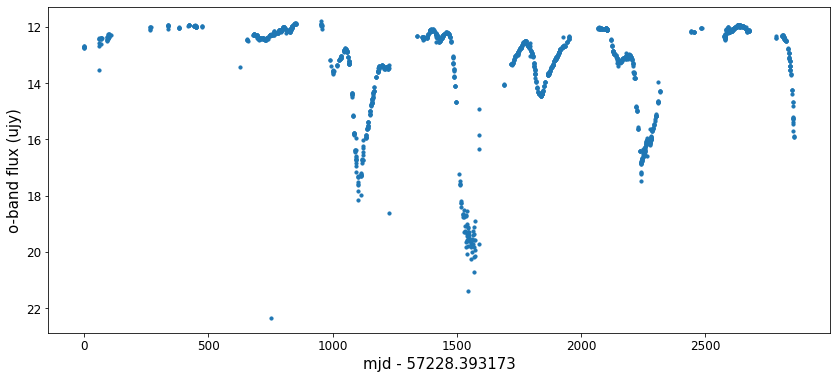

In [9]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band flux (ujy)')
# plt.ylim(top=1.2)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [10]:
median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

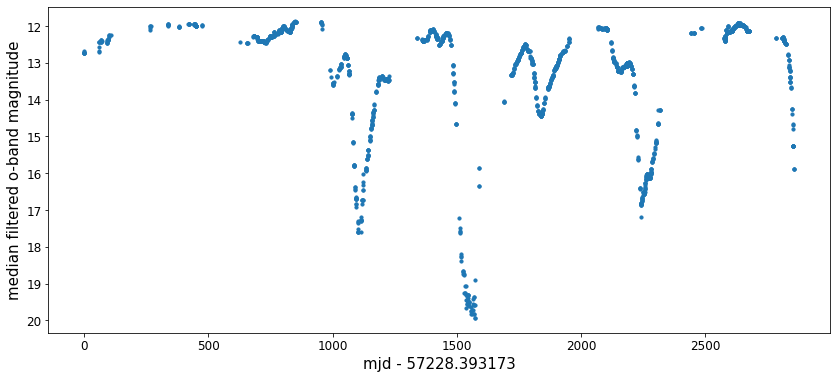

In [11]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
plt.show()

In [12]:
smoothed_flux = convolve(oband['m'], Gaussian1DKernel(20),boundary='extend')

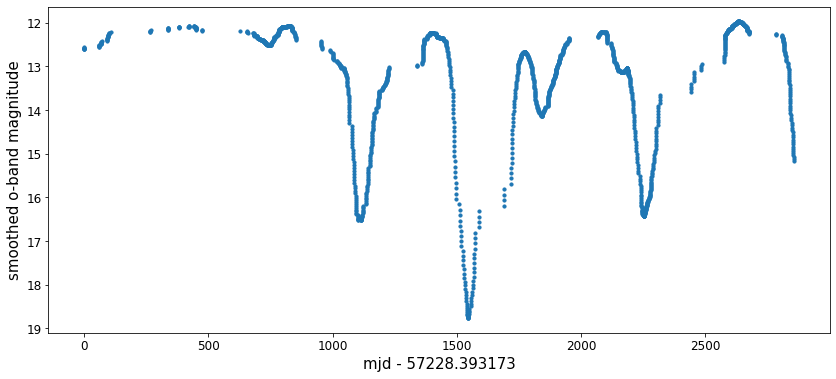

In [13]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],smoothed_flux,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('smoothed o-band magnitude')
plt.show()

In [14]:
savgol_filtered = non_uniform_savgol(np.asarray(oband['mjd']-oband['mjd'][0]),
                                     np.asarray(oband['m']),
                                   window=7, polynom=1)

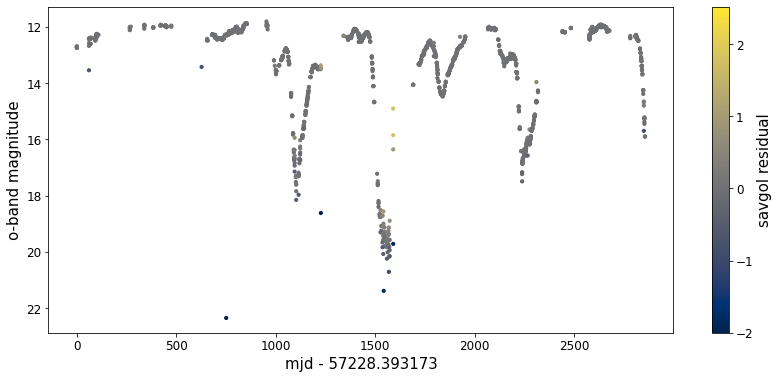

In [15]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=savgol_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.colorbar(label='savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

0.2830460655040933


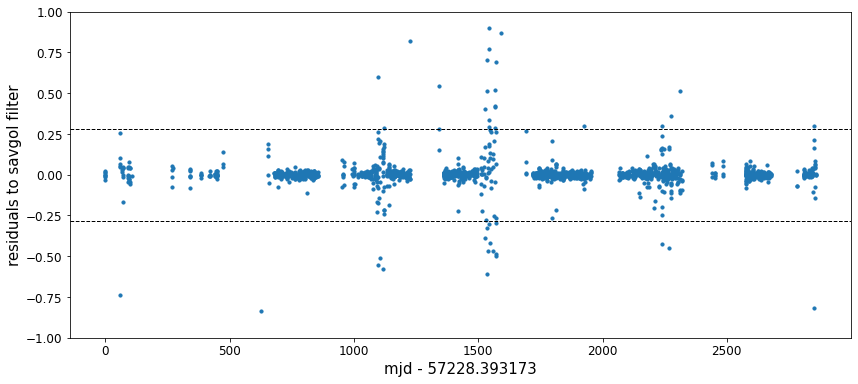

In [16]:
deviation = np.std(savgol_filtered-oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],savgol_filtered-oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

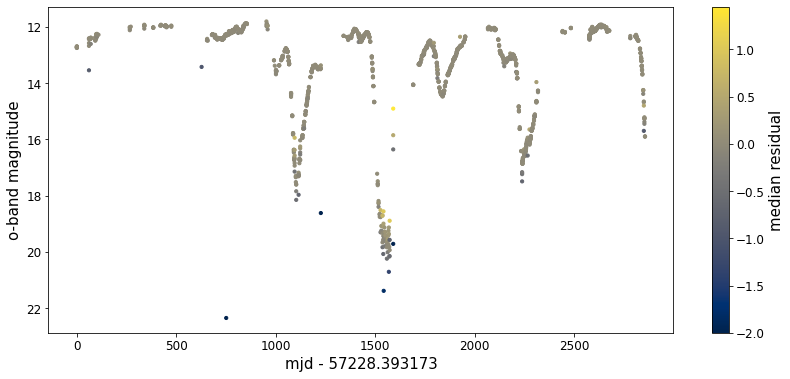

In [17]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=median_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.colorbar(label='median residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

0.30373262055803146


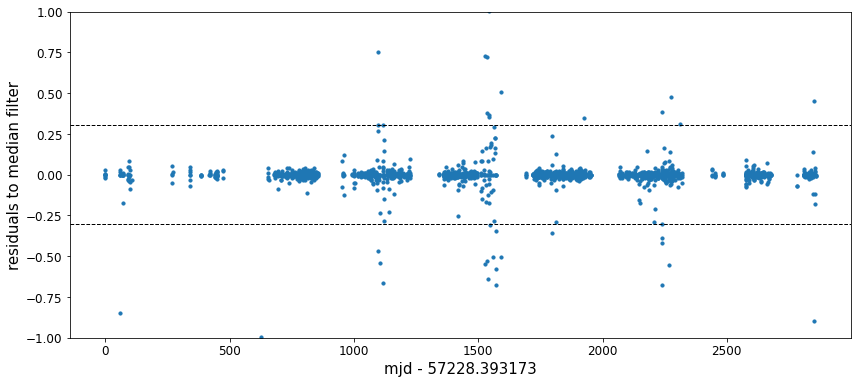

In [18]:
deviation = np.std((median_filtered-oband['m']))
print(deviation)

plt.figure(figsize=(14,6))
# plt.axvline(oband['mjd'][1000]-oband['mjd'][0])
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to median filter')
plt.ylim(-1,1)
plt.show()

In [19]:
mask = np.where(np.abs(savgol_filtered-oband['m'])<0.25,True,False)
mask

# mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
# mask

array([ True,  True,  True, ...,  True,  True,  True])

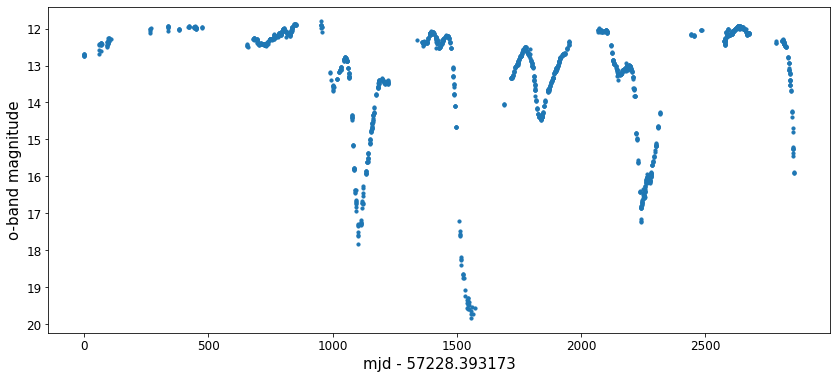

In [20]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [21]:
median_filtered_oband = oband.iloc[mask]
median_filtered_oband.reset_index(drop=True,inplace=True)
median_filtered_oband

savgol_filtered_oband = oband.iloc[mask]
savgol_filtered_oband.reset_index(drop=True,inplace=True)
savgol_filtered_oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.727,0.002,29461.0,73.0,o,0,121.64,295.57660,-20.54654,2602.78,553.75,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
1724,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
1725,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
1726,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [22]:
iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0]),
                                     np.asarray(savgol_filtered_oband['m']),
                                   window=7, polynom=1)

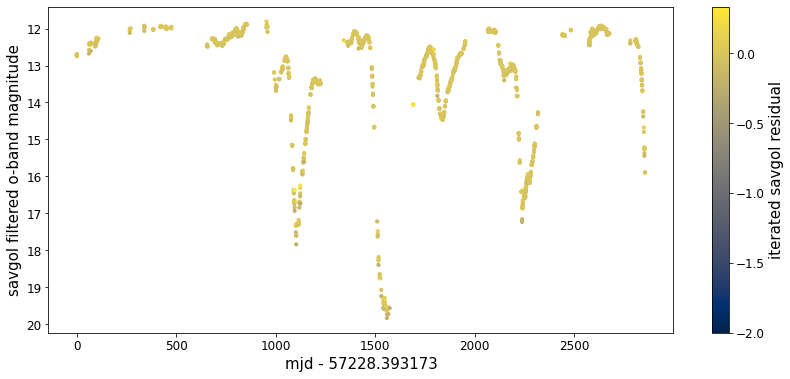

In [23]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
            c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

0.03886188268985682


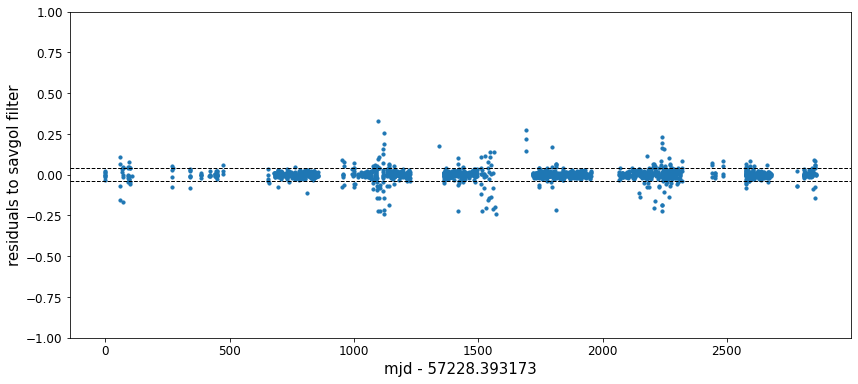

In [24]:
deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
            iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

In [25]:
mjd_scale = savgol_filtered_oband['mjd'][0]

# median_filtered_oband['mjd']-mjd_scale,savgol_filtered
time = savgol_filtered_oband['mjd']-mjd_scale

# stddev_arr = []
# saturation_mask = [False,False,False,False,False]
deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
# print(deviation)

# half_window=20
# for i in range(5,len(time)-5):
#     window_mask = np.where(np.abs(time-time[i])<half_window)
# #     print(window_mask)
# #     print(np.std(iter_savgol_filtered[window_mask]))
#     if np.std(iter_savgol_filtered[window_mask]-np.asarray(savgol_filtered_oband['m'])[window_mask]) > deviation:
# #         print(time[i])
#         saturation_mask.append(True)
#     else:
#         saturation_mask.append(False)
# saturation_mask.append(False)
# saturation_mask.append(False)
# saturation_mask.append(False)
# saturation_mask.append(False)
# saturation_mask.append(False)
# # saturation_mask
# #     stddev_arr.append(np.std)



### find the gaps in the data
time_diff = np.diff(time)
time_diff = np.append(time_diff,0)

gap_mask = []#[False,False]
for i in range(0,len(time)):
    if time_diff[i] > 50:
        gap_mask.append(True)
#     elif (gap_mask[i-1] == True and gap_mask[i-2] == False):
#         gap_mask.append(True)
    else:
        gap_mask.append(False)
        
noise_mask = np.full(len(time),False)
for i in range(0,len(time[gap_mask])):
    if i == 0:
        window = time<=time[time[gap_mask].index[i]]
#         print(window)
    elif i == len(time[gap_mask])-1:
        window = time>=time[time[gap_mask].index[i]]
#         print(window)
    else:
        window = np.logical_and(time>=time[time[gap_mask].index[i]],time<=time[time[gap_mask].index[i+1]])
    if np.std(iter_savgol_filtered[window]-np.asarray(savgol_filtered_oband['m'])[window]) > deviation:
#         print(i,'mask me')
        noise_mask[window] = True
noise_mask

array([False, False, False, ..., False, False, False])

0.03886188268985682


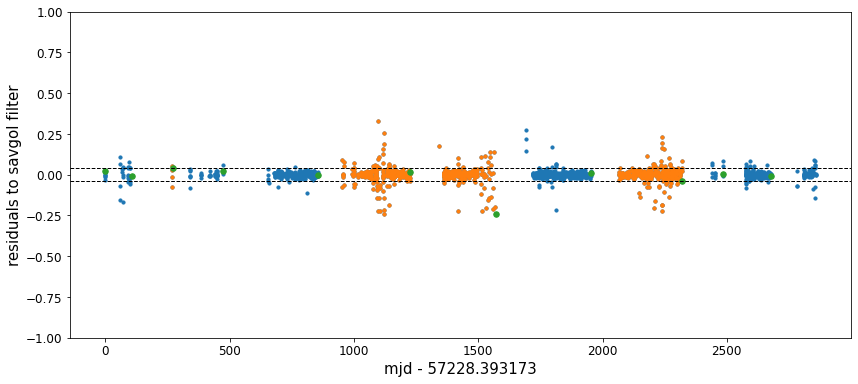

In [26]:
deviation = np.std(iter_savgol_filtered-savgol_filtered_oband['m'])
print(deviation)

plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],
            iter_savgol_filtered-savgol_filtered_oband['m'],s=10)
# plt.scatter(savgol_filtered_oband['mjd'][saturation_mask]-savgol_filtered_oband['mjd'][0],
#             iter_savgol_filtered[saturation_mask]-savgol_filtered_oband['m'][saturation_mask],s=10)
plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
            iter_savgol_filtered[noise_mask]-savgol_filtered_oband['m'][noise_mask],s=10)
plt.scatter(savgol_filtered_oband['mjd'][gap_mask]-savgol_filtered_oband['mjd'][0],
            iter_savgol_filtered[gap_mask]-savgol_filtered_oband['m'][gap_mask],s=30)

plt.axhline(deviation,color='k',linestyle='--')
plt.axhline(-deviation,color='k',linestyle='--')
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to savgol filter')
plt.ylim(-1,1)
plt.show()

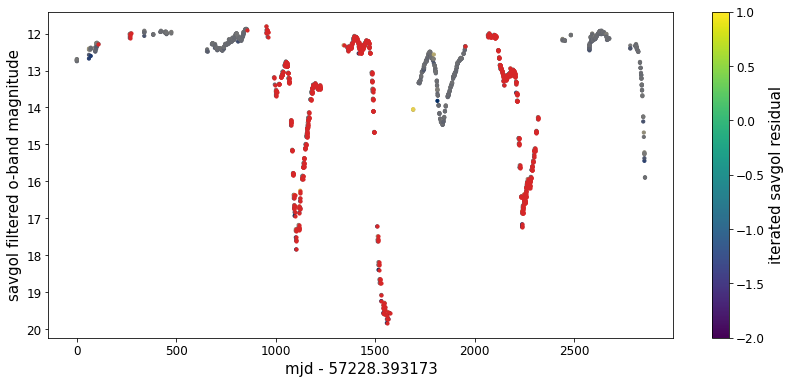

In [27]:
plt.figure(figsize=(14,6))
plt.scatter(savgol_filtered_oband['mjd']-savgol_filtered_oband['mjd'][0],savgol_filtered_oband['m'],s=10,
            c=iter_savgol_filtered-savgol_filtered_oband['m'],cmap='cividis')
plt.scatter(savgol_filtered_oband['mjd'][noise_mask]-savgol_filtered_oband['mjd'][0],
            savgol_filtered_oband['m'][noise_mask],s=10,color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('savgol filtered o-band magnitude')
plt.colorbar(label='iterated savgol residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

In [28]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
edge_detect = sp.ndimage.convolve(median_filtered_oband['m'], [1.0, 0.0, -1.0])

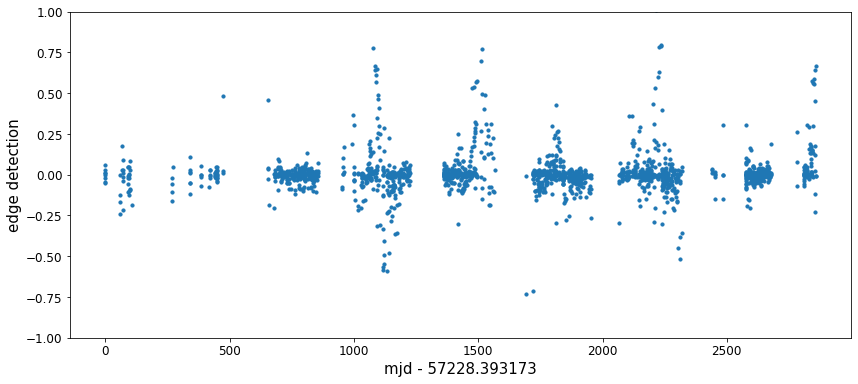

In [29]:
mjd_scale = median_filtered_oband['mjd'][0]


plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('edge detection')
plt.ylim(-1,1)
plt.show()

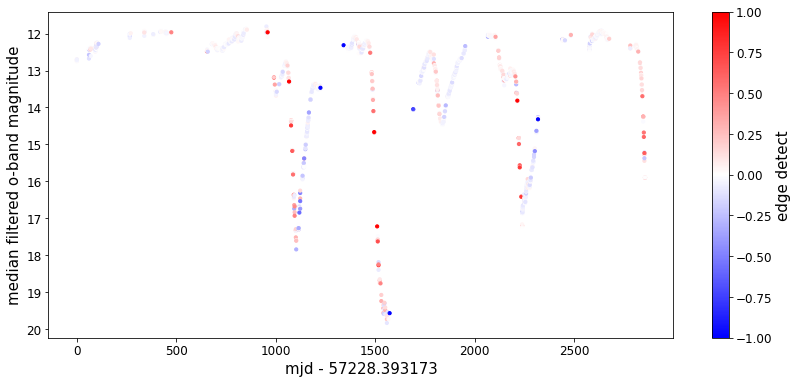

In [30]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
            c=edge_detect,cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-1,1)
plt.show()

### added in a gaussian smooth before the interpolation here

In [31]:
smoothed_flux = convolve(median_filtered_oband['m'], Gaussian1DKernel(20),boundary='extend')

# interpolation_function = sp.interpolate.interp1d(np.asarray(median_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(median_filtered_oband['m']),
#                                                  kind='slinear')
interpolation_function = sp.interpolate.interp1d(np.asarray(median_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(smoothed_flux),
                                                 kind='slinear')
## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(median_filtered_oband['mjd']))
len_data = np.max(median_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
## currently resampling at a resolution of 1 day
resample_flux = interpolation_function(resample_time)

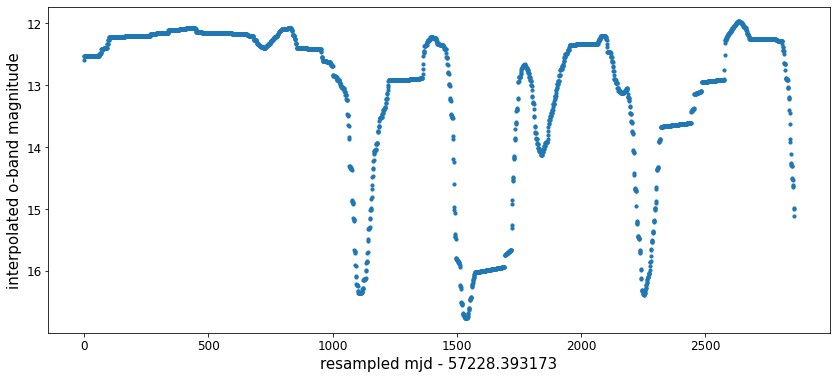

In [32]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.show()

In [33]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

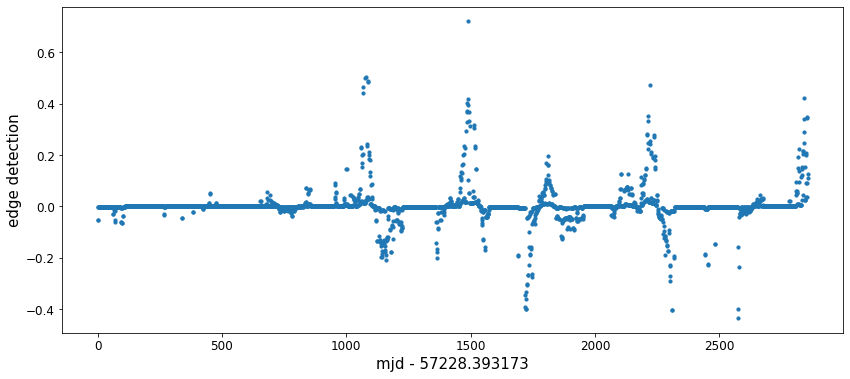

In [34]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

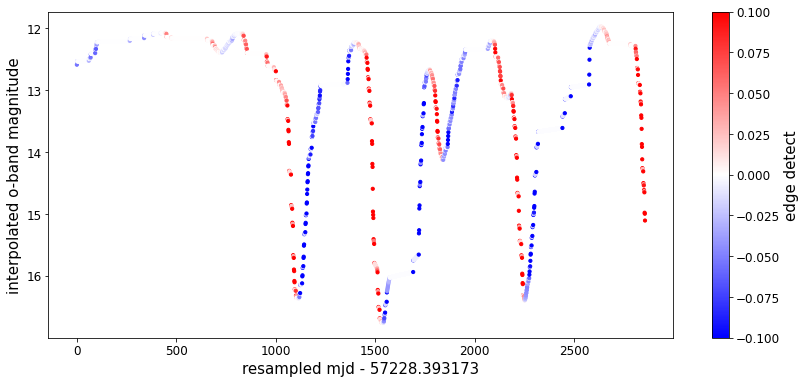

In [35]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Actually all the GP stuff should go here :)

In [36]:
kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# kernel = RBF(length_scale=1,length_scale_bounds=(1e-05, 10)) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [37]:
# median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m']

time = np.asarray(median_filtered_oband['mjd']-mjd_scale)
time = time.reshape(-1,1)

In [38]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(time, median_filtered_oband['m'])
# GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
#                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
#                 n_restarts_optimizer=0, normalize_y=False,
#                 optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(kernel=Matern(length_scale=3, nu=1.5) + WhiteKernel(noise_level=1))

In [39]:
gp.kernel_

Matern(length_scale=102, nu=1.5) + WhiteKernel(noise_level=0.0021)

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [40]:
x_pred = np.linspace(0, int(np.max(time))+1, int(np.max(time))+1).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

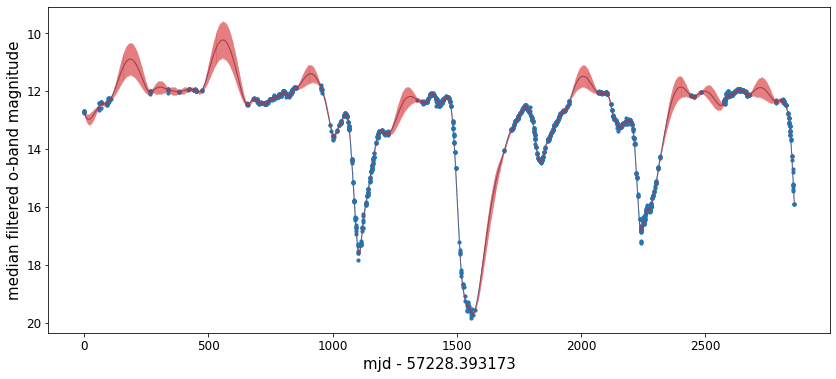

In [41]:
plt.figure(figsize=(14,6))

plt.plot(x_pred,y_pred)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

In [42]:
gpsmoothed_time = time
gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)

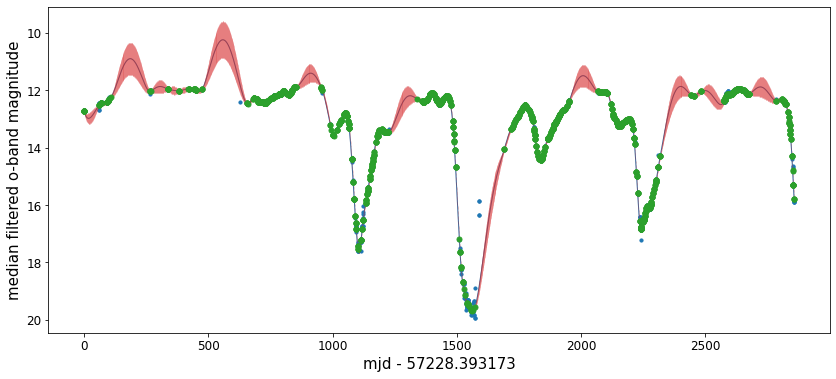

In [43]:
plt.figure(figsize=(14,6))

plt.plot(x_pred,y_pred)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

In [44]:
gp_edge_detect = sp.ndimage.convolve(y_pred, [1.0, 0.0, -1.0])

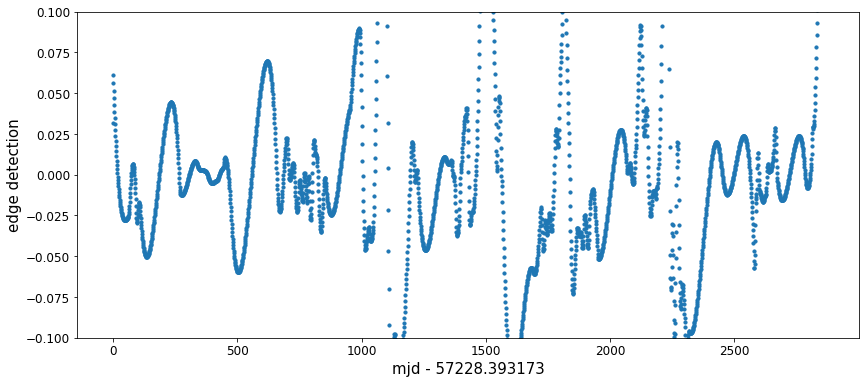

In [45]:
# np.std()

plt.figure(figsize=(14,6))
plt.scatter(x_pred,gp_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
plt.ylim(-0.1,0.1)
plt.show()

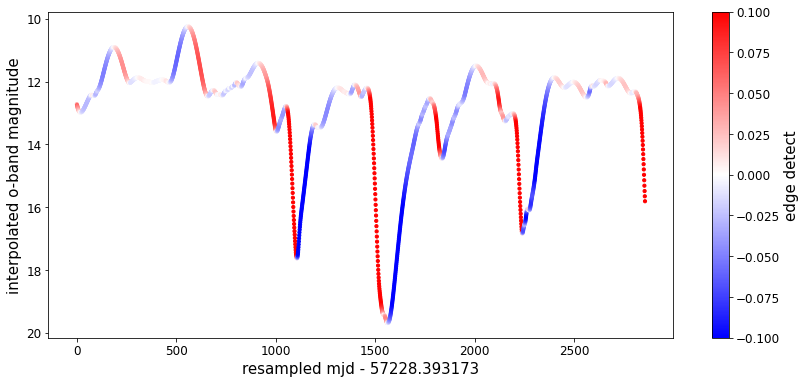

In [46]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(x_pred,y_pred,s=10,
            c=gp_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

In [47]:
## interpolate the edge detection to convert back to the original times
# np.linspace(0, int(np.max(time)), int(np.max(time)))
gp_edgedetect_interp = sp.interpolate.interp1d(x_pred[:,0],
                                                 gp_edge_detect,
                                                 kind='slinear')

gp_edges = gp_edgedetect_interp(median_filtered_oband['mjd']-mjd_scale)

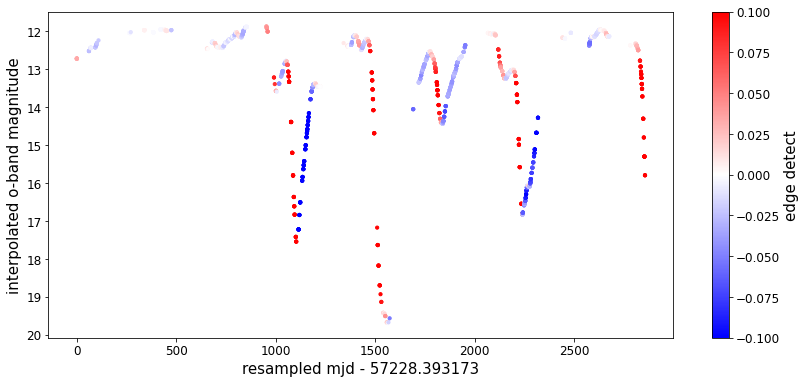

In [48]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(gpsmoothed_time,gpsmoothed_flux,s=10,
            c=gp_edges,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Now back to normal

In [49]:
## interpolate the edge detection to convert back to the original times
# edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
#                                                  new_edge_detect,
#                                                  kind='slinear')

# edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


In [50]:
# plt.figure(figsize=(14,6))
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detect back to real data')
# # plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# # plt.clim(-1,1)
# plt.show()

In [51]:
# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
#             c=(edges_realdata),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

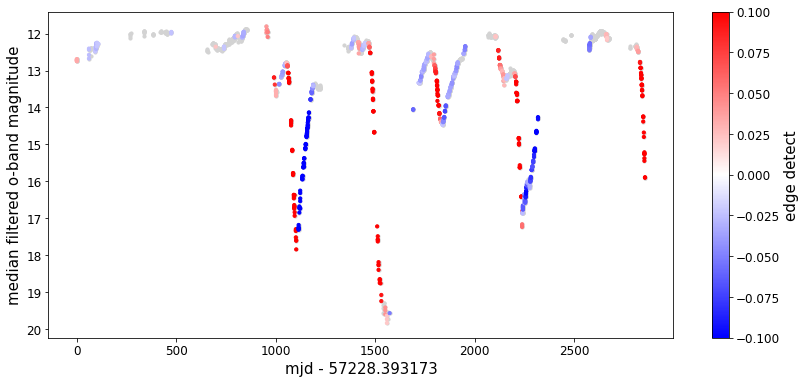

In [52]:
std_dev = np.std(gp_edges)
# std_dev
new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][new_mask]-mjd_scale,median_filtered_oband['m'][new_mask],s=10,
            c=(gp_edges[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

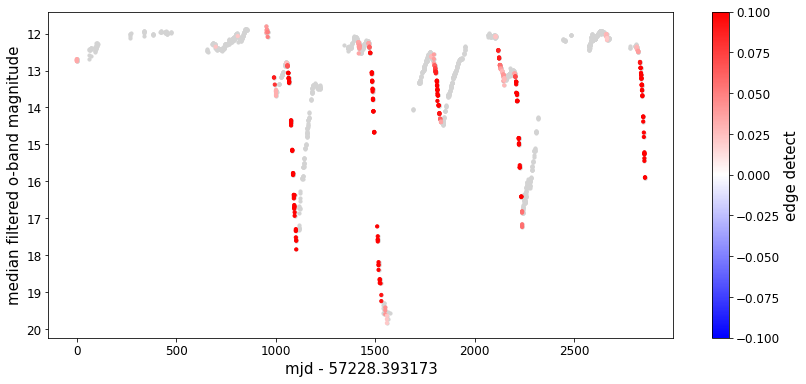

In [53]:
std_dev = np.std(gp_edges)
new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)
downslope_mask = np.where(gp_edges>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [54]:
print(median_filtered_oband['mjd'][total_mask]-mjd_scale)

0          0.000000
1          0.011003
2          0.026038
3          0.036302
4          0.058426
           ...     
1723    2853.921725
1724    2853.937907
1725    2856.891383
1726    2856.893185
1727    2856.896789
Name: mjd, Length: 409, dtype: float64


In [55]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [56]:
run_vals, run_start, run_length = find_runs(total_mask)

In [57]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [58]:
median_filtered_oband['mjd'][downward_mask]-mjd_scale

0          0.000000
306      953.242785
359     1055.101878
631     1415.147358
703     1467.000975
763     1550.863938
861     1783.132147
874     1795.015133
1125    2105.178317
1275    2201.035698
1620    2660.656290
1663    2814.985109
Name: mjd, dtype: float64

In [59]:
median_filtered_oband['mjd'][run_start]

0       57228.393173
8       57289.276473
108     57926.489282
109     57930.495579
250     58037.289013
251     58039.269530
306     58181.635958
326     58233.573266
359     58283.495051
426     58343.374225
631     58643.540531
656     58657.560876
703     58695.394148
755     58769.275694
763     58779.257111
769     58791.225864
861     59011.525320
865     59015.475462
874     59023.408306
927     59067.472874
1125    59333.571490
1171    59385.487983
1275    59429.428871
1321    59469.322207
1620    59889.049463
1635    59897.027001
1663    60043.378282
Name: mjd, dtype: float64

In [60]:
median_filtered_oband['m'][run_start]

0       12.691
8       12.675
108     12.353
109     12.400
250     12.066
251     12.080
306     11.970
326     13.573
359     12.795
426     17.302
631     12.240
656     12.520
703     12.263
755     19.435
763     19.491
769     19.541
861     12.625
865     12.675
874     12.684
927     14.446
1125    12.076
1171    13.234
1275    13.087
1321    16.863
1620    12.022
1635    12.141
1663    12.354
Name: m, dtype: float64

In [61]:
decline_onset = []
decline_end = []
for i in range(0,len(median_filtered_oband['m'][run_start])):
    if i == 0 and np.abs(median_filtered_oband['m'].iloc[0] - median_filtered_oband['m'][run_start[i+1]]) > 0.8:
        ## adding the absolute magnitude should detect beginning declines
        ## NEEDS TO BE TESTED
        decline_onset.append(0)
        print('beginning')
        print('0')
        print(median_filtered_oband['mjd'][0])
        print(np.abs(median_filtered_oband['m'].iloc[0] - median_filtered_oband['m'][run_start[i]]))
    elif i == len(median_filtered_oband['m'][run_start])-1:
        if median_filtered_oband['m'].iloc[-1] - median_filtered_oband['m'][run_start[i]] > 0.8:
            decline_onset.append(run_start[i])
            print('end')
            print(run_start[i])
            print(median_filtered_oband['mjd'][run_start[i]])
            print(median_filtered_oband['m'].iloc[-1] - median_filtered_oband['m'][run_start[i]])
    elif median_filtered_oband['m'][run_start[i+1]] - median_filtered_oband['m'][run_start[i]] > 0.8:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(median_filtered_oband['mjd'][run_start[i]])
        print(median_filtered_oband['m'][run_start[i+1]] - median_filtered_oband['m'][run_start[i]])
#     if i == len(median_filtered_oband['m'][run_start]):
#         print('end')

306
58181.635958
1.6029999999999998
359
58283.495051
4.507
703
58695.394148
7.171999999999999
874
59023.408306
1.7620000000000005
1125
59333.57149
1.1579999999999995
1275
59429.428871
3.776
end
1663
60043.378282
3.537000000000001


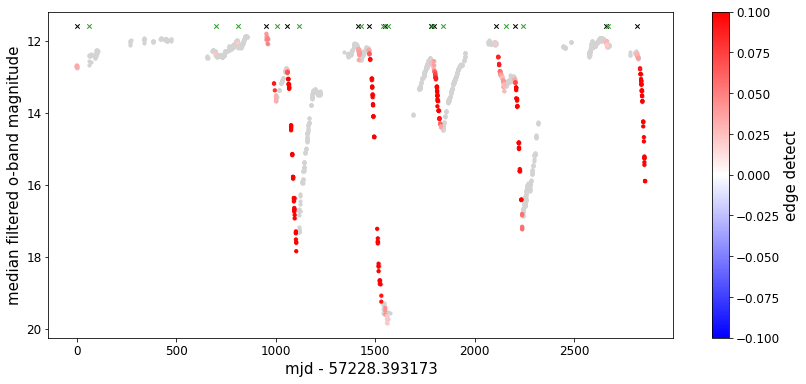

In [62]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][downward_mask]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][downward_mask]),np.min(median_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][upward_mask]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][upward_mask]),np.min(median_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(median_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][decline_onset]),np.min(median_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
plt.show()

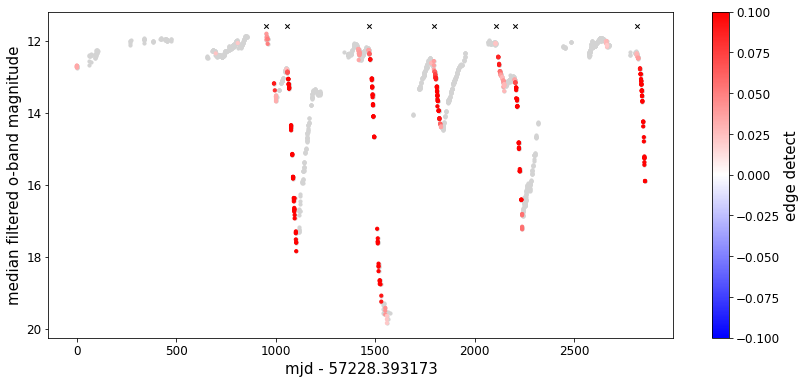

In [63]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(median_filtered_oband['mjd'][downward_mask]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][downward_mask]),np.min(median_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(median_filtered_oband['mjd'][upward_mask]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][upward_mask]),np.min(median_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(median_filtered_oband['mjd'][decline_onset]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][decline_onset]),np.min(median_filtered_oband['m']))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()

In [64]:
savgol_filtered = non_uniform_savgol(np.asarray(median_filtered_oband['mjd']-mjd_scale),
                                     np.asarray(median_filtered_oband['m']),
                                   window=7, polynom=1)

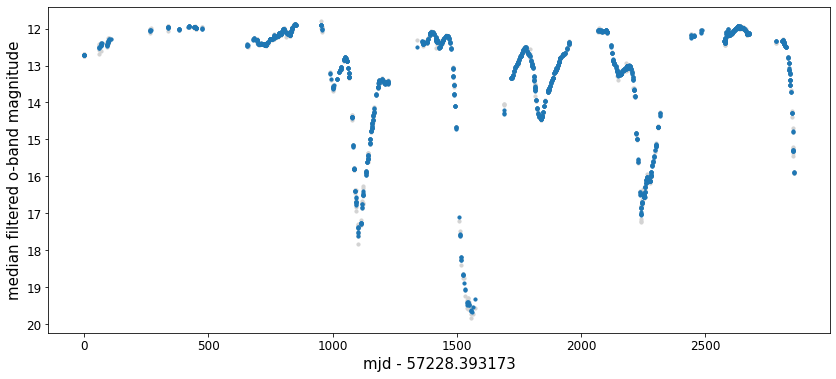

In [65]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd']-mjd_scale,savgol_filtered,s=10)#,color='lightgrey')


plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
# plt.xlim(1200,1500)
plt.show()

In [66]:
# ## thinking about a sliding sigma detection to mask out the point if the std dev is too big (esp at max)

# def generate_saturation_mask(x,y,window_days,stddev_limit):
    

In [67]:
# median_filtered_oband['mjd']-mjd_scale,savgol_filtered
time = median_filtered_oband['mjd']-mjd_scale

stddev_arr = []

half_window=3
for i in range(5,len(time)-5):
    window_mask = np.where(np.abs(time-time[i])<half_window)
    print(np.std(savgol_filtered[window_mask]))
#     stddev_arr.append(np.std)

0.00578859837540611
0.00578859837540611
0.00578859837540611
0.008907228250431536
0.008907228250431536
0.008907228250431536
0.008907228250431536
0.02373456114062231
0.02373456114062231
0.02373456114062231
0.02373456114062231
0.02373456114062231
0.02373456114062231
0.02373456114062231
0.02373456114062231
0.01570017191427044
0.01570017191427044
0.01570017191427044
0.01570017191427044
0.01570017191427044
0.01570017191427044
0.020152924920620662
0.020152924920620662
0.020152924920620662
0.020152924920620662
0.020152924920620662
0.020152924920620662
0.003900911684799396
0.003900911684799396
0.003900911684799396
0.003900911684799396
0.0
0.00958706227469639
0.00958706227469639
0.00958706227469639
0.00958706227469639
0.0
0.010257623676655754
0.010257623676655754
0.010257623676655754
0.010257623676655754
0.010257623676655754
0.010257623676655754
0.010257623676655754
0.007196928720705787
0.007196928720705787
0.007196928720705787
0.007196928720705787
0.007196928720705787
0.0
0.001484475414538671
0

0.00559736081404069
0.00559736081404069
0.00559736081404069
0.00559736081404069
0.00559736081404069
0.00559736081404069
0.00559736081404069
0.00559736081404069
0.00559736081404069
0.00559736081404069
0.004436391730463349
0.004436391730463349
0.004436391730463349
0.004436391730463349
0.008874100605627504
0.008874100605627504
0.008874100605627504
0.008874100605627504
0.008998389978212082
0.008998389978212082
0.008998389978212082
0.008998389978212082
0.008998389978212082
0.008998389978212082
0.008998389978212082
0.008998389978212082
0.008998389978212082
0.008998389978212082
0.0064721301289859335
0.0064721301289859335
0.0064721301289859335
0.0064721301289859335
0.0064721301289859335
0.003358174378470241
0.003358174378470241
0.003358174378470241
0.003358174378470241
0.012811241695217263
0.013970579311081206
0.013970579311081206
0.014813356701563625
0.013831369128008442
0.013831369128008442
0.01378378369503027
0.010653818788103397
0.0023485919281229094
0.0023485919281229094
0.002348591928122